# Disease Diagnosis Deep Learning Model

Acute respiratory distress syndrome (ARDS) is a serious form of repiratory failure that causes low blood oxygen. Its symptoms are difficult to differentiate from other lung conditions and diagnosis often requires invasive surgery.

In this project, we fine-tune a pre-trained LLM to evaluate if a patient has ARDS based on their history of medical notes.

# Install packages

In [ ]:
!pip install transformers --quiet

# Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

df = pd.read_pickle('training.pkl')
df['label'] = df['label'].replace({True: 1, False: 0})

# Preprocessing

### Summarizing notes

In [204]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "don't", "should", "should've", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "ma", "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"]

In [205]:
def select_impressions(text):
  text = text.replace("___", "")
  f = text.split("IMPRESSION:")
  results = ["("+str(idx)+")"+i.split("Note")[0].replace("\n"," ") for idx,i in enumerate(f[1:])]
  return "".join(results)

def remove_stopwords(text):
  f = text.split()
  results = [word for word in f if word.lower() not in stopwords]
  return str(len(results))+" "+" ".join(results)

df['text'] = df['text'].apply(select_impressions)
df['text'] = df['text'].apply(remove_stopwords)

### Oversampling/undersampling

In [186]:
import random

sample= df.iloc[random.sample(range(180,8180), 3600),:]
df_new = pd.DataFrame(np.repeat(df.iloc[0:180,:].values, 20, axis=0))
df_new = df_new.rename(columns={0:'text', 1:'label'})
df = pd.concat([df_new, sample], ignore_index = True)

### Train/test split

In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Parameters

In [195]:
params = {'MAX_LENGTH': 256,
          'EPOCHS': 10,
          'LR': 2e-5,
          'BATCH_SIZE': 64,
          'NUM_STEPS': len(X_train.index) // 64,
          'DISTILBERT_DROPOUT': 0.2,
          'DISTILBERT_ATT_DROPOUT': 0.2,
          'LAYER_DROPOUT': 0.2,
          'SEED':42,
          'CLASS_WEIGHTS': {0:0.1, 1:800}
          }

## Tokenize Text

In [189]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [190]:
def batch_encode(texts, batch_size=256):


    input_ids = []
    attention_mask = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=params['MAX_LENGTH'],
                                             padding='longest',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])


    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [191]:
X_train_ids, X_train_attention = batch_encode(X_train.tolist())
X_valid_ids, X_valid_attention = batch_encode(X_valid.tolist())
X_test_ids, X_test_attention = batch_encode(X_test.tolist())

## Build Model

In [192]:
from transformers import DistilBertConfig, TFDistilBertModel, TFAutoModel

config = DistilBertConfig(dropout=params['DISTILBERT_DROPOUT'],
                          attention_dropout=params['DISTILBERT_ATT_DROPOUT'],
                          output_hidden_states=True)

distilBERT = TFAutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', config=config)

Some layers from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing TFDistilBertModel: ['bert', 'nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertModel were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['distilbert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [196]:
from tensorflow.keras.layers import Input, Dropout, Dense

def build_model():

    kernel_initializer = tf.keras.initializers.GlorotNormal(seed=params['SEED'])

    # Input layers
    input_ids_layer = Input(shape=(params['MAX_LENGTH'],),
                                            name='input_ids',
                                            dtype='int32')
    input_attention_layer = Input(shape=(params['MAX_LENGTH'],),
                                                  name='input_attention',
                                                  dtype='int32')

    # distilBERT output
    last_hidden_state = distilBERT([input_ids_layer, input_attention_layer])[0]
    cls = last_hidden_state[:, 0, :]

    # Classifier
    dropout1 = Dropout(params['LAYER_DROPOUT'],
                       seed=params['SEED']
                       )(cls)
    X = Dense(256,
              activation='relu',
              kernel_initializer=kernel_initializer,
              )(dropout1)
    dropout2 = Dropout(params['LAYER_DROPOUT'],
                       seed=params['SEED']
                       )(X)
    X = Dense(32,
              activation='relu',
              kernel_initializer=kernel_initializer,
              )(dropout2)
    dropout3 = Dropout(params['LAYER_DROPOUT'],
                       seed=params['SEED']
                       )(X)

    # Output layer
    output = Dense(1,
                   activation='sigmoid',
                   kernel_initializer=kernel_initializer,
                   )(dropout3)

    # Create and compile model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=params['LR']),
                  loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=1.5, alpha=0.1),
                  metrics=['Accuracy', tf.keras.metrics.F1Score(average='macro')])

    return model


model = build_model()

## Unfreeze DistilBERT and Fine-tune All Weights

In [197]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=params['LR'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  min_delta=0.02,
                                                  patience=2,
                                                  restore_best_weights=True)
# Train the model
train_history = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.astype('float32').to_numpy(),
    epochs = params['EPOCHS'],
    batch_size = params['BATCH_SIZE'],
    steps_per_epoch = params['NUM_STEPS'],
    validation_data = ([X_valid_ids, X_valid_attention],
                       y_valid.astype('float32').to_numpy()),
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/10
72/72 - 411s - loss: 0.6110 - Accuracy: 0.5432 - f1_score: 0.6682 - val_loss: 0.2123 - val_Accuracy: 0.7118 - val_f1_score: 0.6674 - 411s/epoch - 6s/step
Epoch 2/10
72/72 - 377s - loss: 0.3421 - Accuracy: 0.5933 - f1_score: 0.6682 - val_loss: 0.2153 - val_Accuracy: 0.6997 - val_f1_score: 0.6674 - 377s/epoch - 5s/step
Epoch 3/10
72/72 - 381s - loss: 0.2562 - Accuracy: 0.6803 - f1_score: 0.6682 - val_loss: 0.1787 - val_Accuracy: 0.7552 - val_f1_score: 0.6674 - 381s/epoch - 5s/step
Epoch 4/10
72/72 - 369s - loss: 0.1906 - Accuracy: 0.7641 - f1_score: 0.6682 - val_loss: 0.1201 - val_Accuracy: 0.8420 - val_f1_score: 0.6674 - 369s/epoch - 5s/step
Epoch 5/10
72/72 - 379s - loss: 0.1271 - Accuracy: 0.8563 - f1_score: 0.6682 - val_loss: 0.0822 - val_Accuracy: 0.9149 - val_f1_score: 0.6674 - 379s/epoch - 5s/step
Epoch 6/10
72/72 - 363s - loss: 0.0747 - Accuracy: 0.9234 - f1_score: 0.6683 - val_loss: 0.0596 - val_Accuracy: 0.9392 - val_f1_score: 0.6674 - 363s/epoch - 5s/step
Epoch 7/10

# Evaluate the model

## Test split

Oversampled

In [199]:
from sklearn.metrics import classification_report

size = len(X_test_ids)
step = 100
r = 1400
THRESHOLD2 = 0.5
preds = []
preds_bool = []
for i in range(0,size,step):
  if i + step >= size:
    y_pred = model([X_test_ids[i:], X_test_attention[i:]])
    y_pred_bool = [1 if x > THRESHOLD2 else 0 for x in y_pred]
  else:
    y_pred = model([X_test_ids[i:i+step], X_test_attention[i:i+step]])
    y_pred_bool = [1 if x > THRESHOLD2 else 0 for x in y_pred]
  preds.extend(y_pred)
  preds_bool.extend(y_pred_bool)

print(classification_report(y_temp_test, preds_bool))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       729
           1       0.98      1.00      0.99       711

    accuracy                           0.99      1440
   macro avg       0.99      0.99      0.99      1440
weighted avg       0.99      0.99      0.99      1440



### ROC

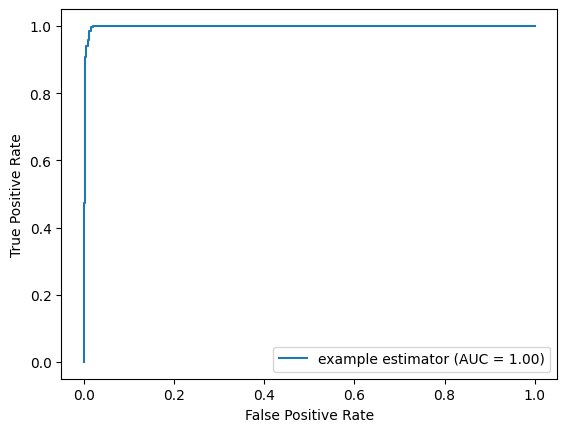

In [201]:
from sklearn import metrics
import random
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

y_true = [1 if x == 1 else 0 for x in y_test]
y_scores = tf.reshape(preds,[-1]).numpy()
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

(0.9902234636871509, 0.51670223)


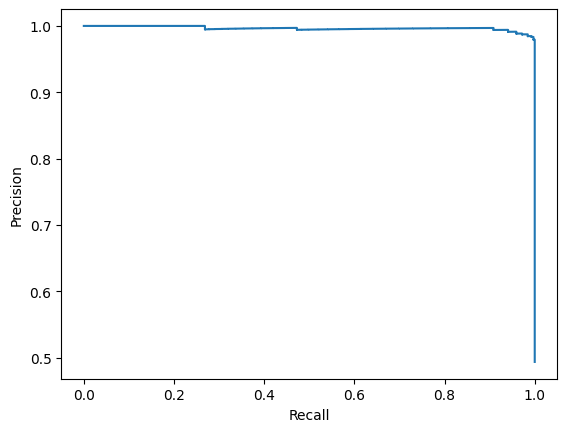

In [202]:
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)

def F1(precision, recall):
  return (2*precision*recall)/(precision+recall)

print(max([(F1(p,r),thresh) for p,r,thresh in zip(precision,recall,thresholds)]))

display = metrics.PrecisionRecallDisplay(precision,recall)
display.plot()
plt.show()

## Original Dataset

Not oversampled

In [ ]:
df = pd.read_pickle('training.pkl')
df['label'] = df['label'].replace({True: 1, False: 0})
df['text'] = df['text'].apply(select_impressions)
df['text'] = df['text'].apply(remove_stopwords)

In [208]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
X_train, X_test, Y_train, Y_test = train_test_split(df.text, df.label, test_size=8000, random_state=0)
X_test_ids, X_test_attention = batch_encode(X_test.tolist())

In [209]:
orig_ids, orig_attention = batch_encode(df['text'].tolist())

In [217]:
THRESHOLD = 0.5427001
size = len(orig_ids)
step = 100
preds = []
tensors = []
for i in range(0,size,step):
  if i + step >= size:
    y_pred = model([orig_ids[i:], orig_attention[i:]])
    y_pred_bool = [1 if x > THRESHOLD else 0 for x in y_pred]
  else:
    y_pred = model([orig_ids[i:i+step], orig_attention[i:i+step]])
    y_pred_bool = [1 if x > THRESHOLD else 0 for x in y_pred]
  tensors.extend(y_pred)
  preds.extend(y_pred_bool)

In [218]:
tf.reshape(tensors,[-1]).numpy()

array([0.71446306, 0.6175705 , 0.5547055 , ..., 0.12794365, 0.12672152,
       0.34336588], dtype=float32)

In [219]:
ground_truth = [1 if x == 1 else 0 for x in df['label']]

In [220]:
print(classification_report(ground_truth, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8000
           1       0.77      0.92      0.84       180

    accuracy                           0.99      8180
   macro avg       0.88      0.96      0.92      8180
weighted avg       0.99      0.99      0.99      8180



In [214]:
metrics.f1_score(ground_truth,preds)

0.7045009784735813

### ROC

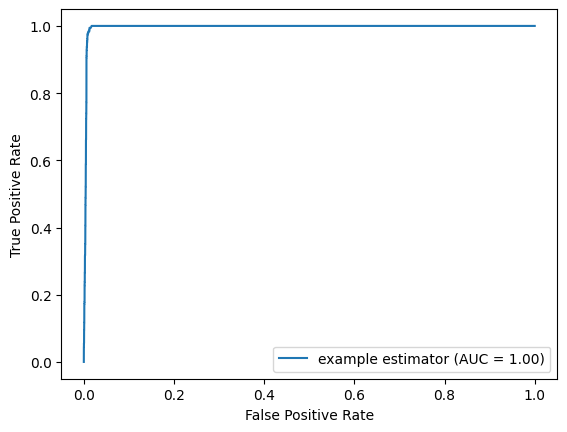

In [215]:
y_true = ground_truth
y_scores = tf.reshape(tensors,[-1]).numpy()
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

(0.8413098236775818, 0.5427001)


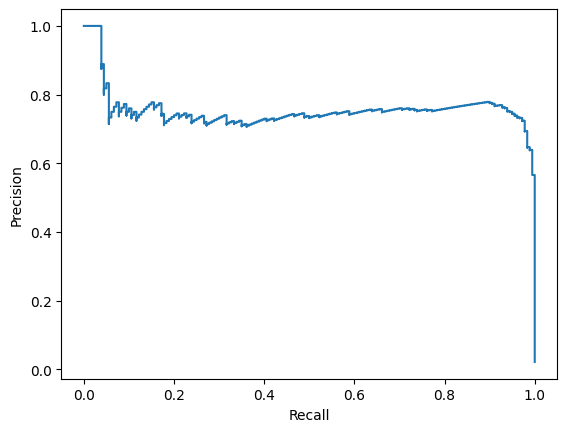

In [216]:
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)

def F1(precision, recall):
  return (2*precision*recall)/(precision+recall)
print(max([(F1(p,r),thresh) for p,r,thresh in zip(precision,recall,thresholds)]))

display = metrics.PrecisionRecallDisplay(precision,recall)
display.plot()
plt.show()